In [109]:
import re
import os
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
# import mpmath
from utils.evaluations_utils import *
import numpy as np
# % matplotlib inline
import matplotlib
import seaborn as sns
from create_entropy_estimation import EntropyEstimation
import re
from typing import List, Iterable, Dict
from numpy import log
from scipy.special import betaln

AVARAGE_RATE_ROUND_FACTOR = 5
sns.set(font_scale=0.8)
import mpmath
from mpmath import mp, mpf,log

mp.dps = 50
# plt.rcParams['figure.figsize'] = [7, 7]
def savefig(title):
    plt.savefig(r"C:\Users\ninit\Documents\university\Idan_Lab\thesis_plots\%s.png"%title, bbox_inches='tight')

In [2]:

def get_ln_number_of_possible_states(k,n):
    n=int(n)
    k=int(k)
    # Assumes binom(n, k) >= 0
    # return -(betaln(1 + n - k, 1 + k) - log(n + 1))
    choose_n = mpf(0.)
    for i in range(n-k,n+1):
        choose_n+=mp.log(i,2)
    choose_k=1
    for i in range(1,k+1):
        choose_k+=mp.log(i,2)
    return (choose_n-choose_k)

def max_ent(l,n):
    return get_ln_number_of_possible_states(l,n)

def binary_ent(l, n):
    l, n = float(l), float(n)
    p = mpf(l) / mpf(n)
    # p = l / n
    # if p>=1. or  p<=0.:
    #     return 0.
    return -((1 - p) * log(1 - p,b=2) + (p) * log(p,b=2))


def binomial_ent(l, n):
    print(l, n)
    p = l / n
    return (1. / 2.) * np.log(2 * np.pi * np.exp(1) * n * p * (1 - p)) / n


file_name_regex = re.compile('(ID_[0-9]+_[0-9]+)')


class CTWHandler():

    def __init__(self):
        self.__data = dict()

    def add_data(self, path: Iterable[str]):
        # data:List[cee.EntropyEstimation]=[]
        for i in path:
            data = EntropyEstimation.load(i)
            if data.tag not in self.__data:
                self.__data[data.tag] = dict()
            if data.file_name not in self.__data[data.tag]:
                self.__data[data.tag][data.file_name] = dict()
            self.__data[data.tag][data.file_name][data.file_index] = data

    def get_item_by_file_name_and_index(self, f_name, index):
        return {k: v[f_name][index] for k, v in self.__data.items()}

    def __len__(self):
        conter = 0
        for kt, vt in self.__data.items():
            for kf, vf in vt.items():
                conter += len(vf)
        return conter

    def get_next_data(self):
        data_list = []
        for kt, vt in self.__data.items():
            for kf, vf in vt.items():
                for ki, vi in vf.items():
                    data_list.append(vi)  #,tree=vi.tree)
        return data_list

    def __iter__(self):
        for kt, vt in self.__data.items():
            for kf, vf in vt.items():
                for ki, vi in vf.items():
                    yield dict(tag=kt, file=kf, entropy=vi.entropy, rate=1000. * np.sum(vi.s) / vi.s.size,
                               n_spikes=np.sum(vi.s), l_segemnt=vi.s.size,index = vi.file_index)  #,,tree=vi.tree)
    def get_spikes(self,df):
        spike_dict = dict()
        for i in df.iterrows():
            spike_dict[(i['full_tag'],i['file'])]=self.__data[i['tag']][i['file']]
    def to_df(self, tag_regex_to_remove: str | List[str] = '', normelize_entropy=True,
              group_dict: Dict[str, str] | None = None):
        key_data_arr = dict(full_tag=[], file=[], entropy=[], rate=[],
                            n_spikes=[], Model=[], l_segemnt=[],index=[])#, normalized_entropy=[])
        if isinstance(tag_regex_to_remove, str):
            tag_regex_to_remove = [tag_regex_to_remove]
        if group_dict is not None:
            group_dict = {k: re.compile(f'{v}') for k, v in group_dict.items()}
        for kv in self:
            for k, v in kv.items():
                if k == 'tag':
                    # disp_v = v
                    # for i in tag_regex_to_remove:
                    #     disp_v = re.sub(i, '', disp_v)
                    # disp_v = re.sub('([0-9]+-[0-9]+)',
                    #                 lambda x: x.group(1).replace('-', '.') if x.group(1) is not None else None,
                    #                 disp_v)  # replacing to decimal point
                    # key_data_arr['tag'].append(v)
                    if group_dict is not None:
                        unique_flag = None
                        empty_flag = False
                        v_groups_data_for_warning = []
                        for k_group, v_group in group_dict.items():
                            if v_group.match(v):
                                v_groups_data_for_warning.append((v, v_group))
                                key_data_arr["Model"].append(k_group)
                                if unique_flag is None:
                                    unique_flag = True
                                else:
                                    unique_flag = False
                                empty_flag = True
                        assert unique_flag is None or unique_flag, 'Keys of group are not unique ' + ' and '.join(
                            v_groups_data_for_warning)
                        assert empty_flag, 'one key has no group ' + v
                    else:
                        key_data_arr["Model"].append('')
                    key_data_arr['full_tag'].append(v)
                elif k == 'file':
                    v = file_name_regex.match(v).group(1)
                    key_data_arr[k].append(v)
                elif k == 'entropy':

                    key_data_arr[k].append(v)
                elif k == 'spikes':
                    key_data_arr[k].append(v.astype(int).tolist())
                else:
                    key_data_arr[k].append(v)

        df = pd.DataFrame(data=key_data_arr)
        # df['sim_id']=df['file']+'@'+df['sim_index']
        # df.drop(columns=['file','sim_index'],inplace=True)
        # df['entropy']= df['entropy']*df['l_segemnt']
        return df

    def add_min_isi(self):

        data_arr = self.get_next_data()
        min_isi = {k: None for k in self.__data.keys()}
        for i in data_arr:
            indexes = np.where(i.s == 1)[0]
            cur_min_isi = np.min(indexes[1:] - indexes[:-1] - 1)
            if min_isi[i.tag] is None:
                min_isi[i.tag] = cur_min_isi
            elif min_isi[i.tag] > cur_min_isi:
                min_isi[i.tag] = cur_min_isi
        return min_isi

    def add_normalized(self, df, compress_to_minimal=False):
        tags = df['full_tag']

        if compress_to_minimal:
            min_isi_dict = self.add_min_isi()
            min_isi = np.array([min_isi_dict[t] for t in tags])
            print(f'min isi = {min_isi_dict}')
            df['normalizing_factor'] = df[['n_spikes', 'l_segemnt']].apply(
                lambda x: max_ent(x[0], x[1] - (x[0] * min_isi)),axis=1)
                # lambda x: binary_ent(x[0], x[1] - (x[0] * min_isi)),axis=1)
        else:
            df['normalizing_factor'] = df[['n_spikes', 'l_segemnt']].apply(
                lambda x: max_ent(x[0], x[1]),axis=1)
                # lambda x: binary_ent(x[0]+1, x[1]),axis=1)

        df['normalized_entropy'] = df['entropy']*df['l_segemnt'] / df['normalizing_factor']
        # df['normalized_entropy'] = df['normalized_entropy']



    # def add_log_prob(self,df):
    #     df['log_prob'] = -df['entropy'] * df['l_segemnt']

    def get_Q0(self,df):
        N=df['normalizing_factor'].apply(lambda x:mp.power(2,x))
        # print(N)
        denomenator = (mpf(1.)+mpf(1.)/N)*N.apply(lambda n :mp.log(n+1,2))-2*(mpf(1.)+df['normalizing_factor'])+df['normalizing_factor']
        # print(denomenator)
        df['Q0']=-mpf(2.)/denomenator


    def get_statistical_complexity(self,df):
        ans=df['Q0']*df['normalized_entropy']/df['l_segemnt']
        p=-df['l_segemnt']*(df['entropy'].apply(lambda x:mp.power(2,x)))
        p_e=df['normalizing_factor'].apply(lambda x:mp.power(2,-x))/df['l_segemnt']
        # ans*=(((p+p_e)/mpf(2.)).apply(lambda x:mp.log(x,2))-0.5*(-df['normalizing_factor']+df['log_prob']))
        df['H_M']=((p+p_e)/mpf(2.)).apply(lambda x:-mp.log(x,2))
        # df['H_M']=(df['entropy']+df['normalizing_factor'])/mpf(2.)
        df['Q'] = df['H_M']-(df['entropy']+df['normalizing_factor'])/mpf(2.)
        ans*=df['Q']
        df['complexity']=ans


In [3]:
#set params for handler
models = {}
regex_match =re.compile(r".*_CTW")
gmax_value_regex = re.compile('([0-9](?:\.[0-9])?)[a-z,A-Z]*')
models_pathes = []
counter = 0
for i in os.listdir('entropy_data'):
    counter+=1
    cur_dir_path = os.path.join('entropy_data', i)
    if regex_match.match(i) and os.path.isdir(cur_dir_path) and 'current' not in i:
        for j in os.listdir(cur_dir_path):
            models_pathes.append(os.path.join(cur_dir_path, j))
    # if counter ==3:
    #     break
remove_v = True

In [4]:

c = CTWHandler()
c.add_data(models_pathes)
df = c.to_df(
    tag_regex_to_remove=['Rat_L5b_PC_2_Hay_', '(?:_noNMDA_CTW)', 'noNMDA_', '_CTW', 'current_injection_synapses_',
                         ' Human_L23_PC_0603_11_937_Eyal_', 'morph_from_Rat_L5b_PC_2_Hay_', 'factor_'],
    group_dict={'Rat L5PC': 'Rat_L5b_PC_2_Hay_(?:(?:[0-9]-)?[0-9]|(?:DC_[0-9]{2}))_CTW',
                'Rat L5PC w/o NMDA': 'Rat_L5b_PC_2_Hay_(?:noNMDA_(?:[0-9]-)?[0-9]|(?:[0-9]-)?[0-9]_noNMDA)_CTW',
                'Human L23': 'Human_L23_PC_0603_11_937_Eyal_(?:[0-9]-)?[0-9]_CTW',
                'Rat L5PC DC': 'Rat_L5b_PC_2_Hay_factor_(?:(?:[0-9]-)?[0-9]|(?:DC_[0-9]{1,3}))_DC_-?[0-9]{1,3}_CTW',
                'Rat L5PC w/o NMDA DC': 'Rat_L5b_PC_2_Hay_noNMDA_factor_(?:(?:[0-9]-)?[0-9]|(?:DC_[0-9]{1,3}))_DC_-?[0-9]{1,3}_CTW',
                'Human L23 rat morph': 'Human_L23_PC_0603_11_937_Eyal_morph_from_Rat_L5b_PC_2_Hay_(?:[0-9]-)?[0-9]_CTW',
                'Current Synapse Rat L5PC': 'Rat_L5b_PC_2_Hay_current_injection_synapses_(?:[0-9]-)?[0-9]_CTW',
                'Current Synapse Rat L5PC w/o NMDA': 'Rat_L5b_PC_2_Hay_current_injection_synapses_(?:noNMDA_(?:[0-9]-)?[0-9]|(?:[0-9]-)?[0-9]_noNMDA)_CTW'}, )
for i in df['full_tag'].unique():
    df.loc[df['full_tag'] == i, 'Average Rate Per Parameters'] = np.round(df.loc[df['full_tag'] == i, 'rate'].mean(),
                                                                          AVARAGE_RATE_ROUND_FACTOR)

get_factor_from_tag_match = re.compile('^.*(?!DC)_([0-9](?:(?:\-|\.)[0-9]+)?)[^0-9\s]{3}.*$')
get_dc_from_tag_match = re.compile('^.*DC_(-?[0-9]{1,3})[^0-9\s]*$')


def convert_tag_to_weight_factor(x):
    a = get_factor_from_tag_match.match(x)
    # print(x)

    if a is None:
        return 1.
    a = a.group(1)
    a = a.replace('-', '.')
    # if a != x: print(x, a)

    return float(a)


def convert_tag_to_dc_factor(x):
    a = get_dc_from_tag_match.match(x)
    if a is None:
        return -70
    a = a.group(1)
    sign = int('-' not in a) * 2 - 1
    a = a.replace('-', '')
    # if a != x: print(x, a)
    return sign * float(a)


df['factor'] = df['full_tag'].apply(convert_tag_to_weight_factor)
df['DC_factor'] = df['full_tag'].apply(convert_tag_to_dc_factor)
df.drop_duplicates()
# factor_order = {i: convert_tag_to_weight_factor(i) for i in df['tag'].unique()}
df['DC_test'] = df["Model"].apply(lambda x: True if 'DC' in x else False)

In [5]:
c.add_normalized(df, False)
# c.get_Q0(df)
df

,full_tag,file,entropy,rate,n_spikes,Model,l_segemnt,index,Average Rate Per Parameters,factor,DC_factor,DC_test,normalizing_factor,normalized_entropy
0,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_0_512971,0.07331939743785011051183606399708933761134897...,10.644628,644.0,Human L23,60500,26,12.87229,0.5,-70.0,False,5153.62109737010929413386888300465724165182713...,0.86071976600172073164813734760946649488993029...
1,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_10_10035,0.07991678035022505451154769401079127840611434...,11.074380,670.0,Human L23,60500,1,12.87229,0.5,-70.0,False,5322.83246699401844346510554748485833967803403...,0.90834442774019569973745706038827367852010582...
2,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_11_137787,0.08772599437653970280158639015680735121497972...,12.198347,738.0,Human L23,60500,28,12.87229,0.5,-70.0,False,5758.56651399116440934914882659891512154993653...,0.92165691702711057766821058174828011686222294...
3,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_12_171396,0.07331832661511796170538780025507500534212662...,10.280992,622.0,Human L23,60500,7,12.87229,0.5,-70.0,False,5009.24977482206603249912565028263016378762386...,0.88551359177776269498099221027208533229729151...
4,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_14_159701,0.04180181519812520512231381031205606187760665...,5.173554,313.0,Human L23,60500,67,12.87229,0.5,-70.0,False,2836.92197361436739048388982406116403674170145...,0.89146259326424180181787186233475782324408636...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5249,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,ID_94_138606,0.12002847635951190409662200419250815276413730...,17.050000,1023.0,Rat L5PC w/o NMDA DC,60000,26,17.96978,1.0,30.0,True,7480.94655431536779688091139990610747522085582...,0.96267344369896938615960818931210455037412871...
5250,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,ID_97_825545,0.12725888420953751451770905426330285768734510...,22.083333,1325.0,Rat L5PC w/o NMDA DC,60000,12,17.96978,1.0,30.0,True,9187.34189314019374384882397439054558523850938...,0.83109272969077007764749084560460280239878717...
5251,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,ID_98_997266,0.10772123610919551373877180534341137041443545...,14.516667,871.0,Rat L5PC w/o NMDA DC,60000,83,17.96978,1.0,30.0,True,6574.52831050177065251273889363755921946575329...,0.98307800366874549711301207744524703210245883...
5252,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,ID_99_660806,0.14154962931936304399752814087336941502784288...,22.350000,1341.0,Rat L5PC w/o NMDA DC,60000,9,17.96978,1.0,30.0,True,9274.68998610493653068573204813518649633329824...,0.91571554110010234339639046090844567271896961...


In [6]:
# c.add_log_prob(df)
# df
df['Maximal Conductance']=df['factor'].apply(lambda x:x*0.0007)
df

,full_tag,file,entropy,rate,n_spikes,Model,l_segemnt,index,Average Rate Per Parameters,factor,DC_factor,DC_test,normalizing_factor,normalized_entropy,Maximal Conductance
0,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_0_512971,0.07331939743785011051183606399708933761134897...,10.644628,644.0,Human L23,60500,26,12.87229,0.5,-70.0,False,5153.62109737010929413386888300465724165182713...,0.86071976600172073164813734760946649488993029...,0.00035
1,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_10_10035,0.07991678035022505451154769401079127840611434...,11.074380,670.0,Human L23,60500,1,12.87229,0.5,-70.0,False,5322.83246699401844346510554748485833967803403...,0.90834442774019569973745706038827367852010582...,0.00035
2,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_11_137787,0.08772599437653970280158639015680735121497972...,12.198347,738.0,Human L23,60500,28,12.87229,0.5,-70.0,False,5758.56651399116440934914882659891512154993653...,0.92165691702711057766821058174828011686222294...,0.00035
3,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_12_171396,0.07331832661511796170538780025507500534212662...,10.280992,622.0,Human L23,60500,7,12.87229,0.5,-70.0,False,5009.24977482206603249912565028263016378762386...,0.88551359177776269498099221027208533229729151...,0.00035
4,Human_L23_PC_0603_11_937_Eyal_0-5_CTW,ID_14_159701,0.04180181519812520512231381031205606187760665...,5.173554,313.0,Human L23,60500,67,12.87229,0.5,-70.0,False,2836.92197361436739048388982406116403674170145...,0.89146259326424180181787186233475782324408636...,0.00035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5249,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,ID_94_138606,0.12002847635951190409662200419250815276413730...,17.050000,1023.0,Rat L5PC w/o NMDA DC,60000,26,17.96978,1.0,30.0,True,7480.94655431536779688091139990610747522085582...,0.96267344369896938615960818931210455037412871...,0.00070
5250,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,ID_97_825545,0.12725888420953751451770905426330285768734510...,22.083333,1325.0,Rat L5PC w/o NMDA DC,60000,12,17.96978,1.0,30.0,True,9187.34189314019374384882397439054558523850938...,0.83109272969077007764749084560460280239878717...,0.00070
5251,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,ID_98_997266,0.10772123610919551373877180534341137041443545...,14.516667,871.0,Rat L5PC w/o NMDA DC,60000,83,17.96978,1.0,30.0,True,6574.52831050177065251273889363755921946575329...,0.98307800366874549711301207744524703210245883...,0.00070
5252,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,ID_99_660806,0.14154962931936304399752814087336941502784288...,22.350000,1341.0,Rat L5PC w/o NMDA DC,60000,9,17.96978,1.0,30.0,True,9274.68998610493653068573204813518649633329824...,0.91571554110010234339639046090844567271896961...,0.00070


In [112]:
# df[df['whole_seg_entropy']>df['normalizing_factor']]
# c.get_statistical_complexity(df)
# df
sns.set_style("white")
sns.despine()

<Figure size 640x480 with 0 Axes>

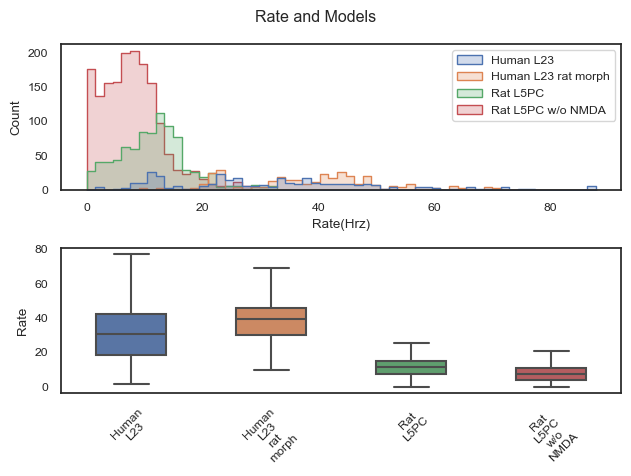

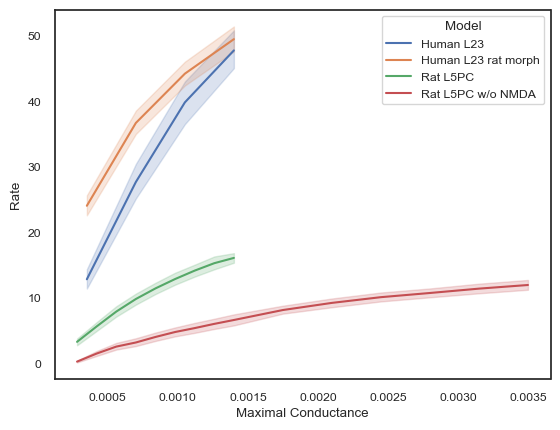

In [96]:
filtered_df = df[~df["Model"].str.contains("DC")] #remove dc groups
fig, ax = plt.subplots(2)
sns.histplot(filtered_df, x='rate', hue="Model", element="step", ax=ax[0])
ax[0].set_xlabel("Rate(Hrz)")
sns.boxplot(filtered_df, x="Model", y='rate', ax=ax[1], width=0.5, showfliers=False)
ax[1].set_xlabel("")
# ax[0].legend(title="")
# sns.box
legend = ax[0].legend_
legend.set_title('')


ax[1].set_ylabel("Rate")

# Set the labels with line breaks and rotation if needed
labels = [item.get_text() for item in ax[1].get_xticklabels()]
new_labels = [label.replace(' ', '\n') for label in labels]
ax[1].set_xticklabels(new_labels, rotation=45) # Set the rotation if needed

plt.suptitle("Rate and Models")
plt.tight_layout()
plt.grid(False)
savefig("rate as function of model")
plt.show()


ax = sns.lineplot(filtered_df, x='Maximal Conductance', y='rate', hue="Model")
plt.grid(False)
ax.set_ylabel('Rate')
savefig("gmax_and_")
plt.show()



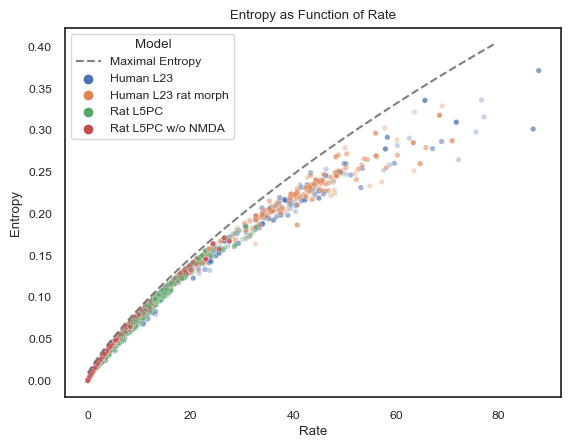

In [108]:
ax = plt.subplot()
ax.plot([i for i in range(80)],[max_ent(i,1000)/1000 for i in range(80)],color="black",label="Maximal Entropy", linestyle='--',alpha =0.5)
ax = sns.scatterplot(data=df[~df["Model"].str.contains("DC")], x="rate", y="entropy", hue="Model", sizes=(5, 200),s=15,alpha=0.3,ax=ax)
ax.set(title='Entropy as Function of Rate')
ax.set_xlabel('Rate')
ax.set_ylabel('Entropy')
plt.grid(False)
savefig("entropy_as_function_of_rate")

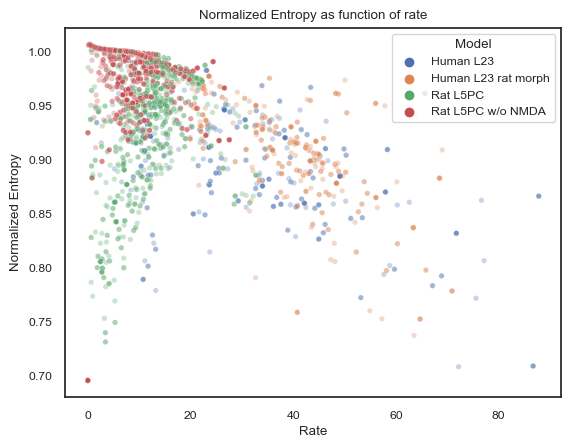

In [70]:
ax = sns.scatterplot(data=df[~df["Model"].str.contains("DC")], x="rate", y="normalized_entropy", hue="Model", sizes=(5, 200), s=15,alpha=0.3)
ax.set(
    title='Normalized Entropy as function of rate')
ax.set_xlabel('Rate')
ax.set_ylabel('Normalized Entropy')
plt.grid(False)
savefig("nentropy_as_function_of_rate")

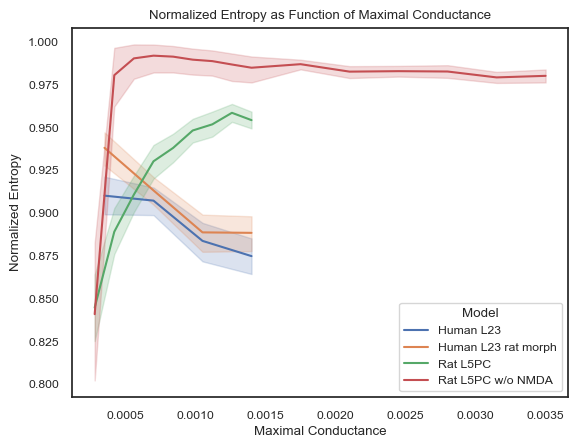

In [88]:

temp_df = df[~df["Model"].str.contains("DC")].copy()
temp_df['normalized_entropy']=temp_df['normalized_entropy'].apply(lambda x:np.float64(x))
ax = sns.lineplot(temp_df, x='Maximal Conductance', y='normalized_entropy', hue="Model")
plt.grid(False)
ax.set_ylabel('Normalized Entropy')
plt.title("Normalized Entropy as Function of Maximal Conductance")

savefig("nentropy_as_function_of_gmax")

plt.show()
# plt.grid(False)



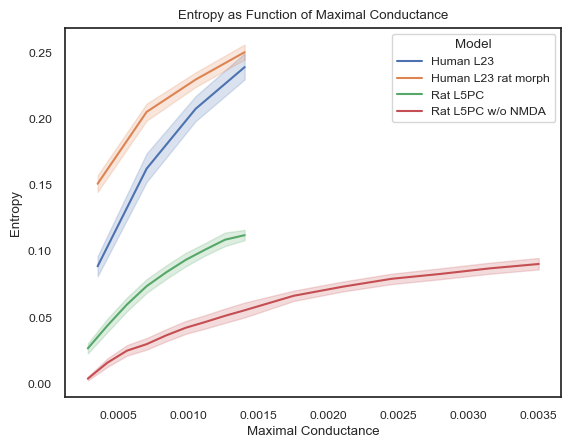

In [87]:

temp_df = df[~df["Model"].str.contains("DC")].copy()
temp_df['entropy']=temp_df['entropy'].apply(lambda x:np.float64(x))
ax = sns.lineplot(temp_df, x='Maximal Conductance', y='entropy', hue="Model")
plt.grid(False)
plt.title("Entropy as Function of Maximal Conductance")
ax.set_ylabel('Entropy')
savefig("entropy_as_function_of_gmax")
plt.show()


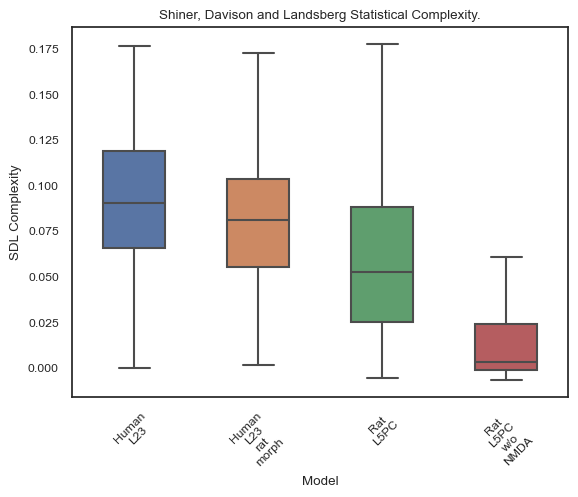

In [113]:


temp_df = df.copy()
temp_df['complexity'] =temp_df['normalized_entropy'].apply(lambda x : x*(1-x))
ax = sns.boxplot(temp_df[~temp_df["Model"].str.contains("DC")], x="Model", y='complexity',  width=0.5, showfliers=False)
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [label.replace(' ', '\n') for label in labels]
ax.set_xticklabels(new_labels, rotation=45)
ax.set_ylabel("SDL Complexity")
plt.title("Shiner, Davison and Landsberg Statistical Complexity.")
plt.grid(False)
savefig("SDLBoxplot")
del temp_df


C:\Users\ninit\AppData\Local\Temp\ipykernel_27160\1572782688.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['complexity'] = filtered_df['complexity'].apply(lambda x: np.float64(x))


0.00013156682803510918
2.415309106682438e-31
1.3113723280413308e-147
9.345404900879401e-17
1.9341854580182728e-137
1.4583974872155178e-175


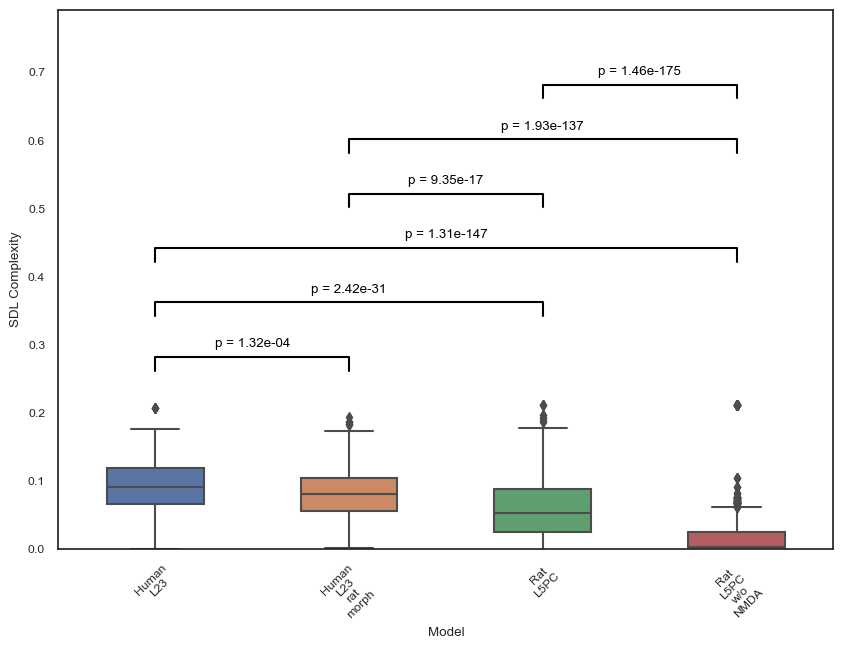

In [93]:
from scipy.stats import mannwhitneyu
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from itertools import combinations

# Assuming df is your original DataFrame

# Copy and process the dataframe
temp_df = df.copy()
temp_df['complexity'] = temp_df['normalized_entropy'].apply(lambda x: x * (1 - x))
filtered_df = temp_df[~temp_df["Model"].str.contains("DC")]

# Convert 'mpf' types in 'complexity' column to standard Python floats
filtered_df['complexity'] = filtered_df['complexity'].apply(lambda x: np.float64(x))

# Compute pairwise Mann-Whitney U tests and p-values
models = filtered_df["Model"].unique()
comparisons = list(combinations(models, 2))
p_values = {}
for model1, model2 in comparisons:
    group1 = filtered_df[filtered_df["Model"] == model1]["complexity"]
    group2 = filtered_df[filtered_df["Model"] == model2]["complexity"]
    _, p = mannwhitneyu(group1, group2)
    p_values[(model1, model2)] = p

# Plotting with significance annotations
plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=filtered_df, x="Model", y='complexity', width=0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [label.replace(' ', '\n') for label in labels]
ax.set_xticklabels(new_labels, rotation=45)
def annotate_significance(ax, x1, x2, y, p_value):
    """Annotate the boxplot with the p-value."""
    ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], color='black')
    text = f'p = {p_value:.2e}'
    ax.text((x1 + x2) / 2, y + 0.03, text, ha='center', va='bottom', color='black')

# Annotate significance
max_y = filtered_df['complexity'].max()
for (model1, model2), p_value in p_values.items():
    x1 = new_labels.index(model1.replace(' ', '\n'))
    x2 = new_labels.index(model2.replace(' ', '\n'))
    annotate_significance(ax, x1, x2, max_y + 0.05, p_value)
    max_y += 0.08
    print(p_value)
plt.ylim(0, max_y + 0.1)
ax.set_ylabel("SDL Complexity")
plt.grid(False)
savefig("SDLBoxplot_p_val")

plt.show()

del temp_df


In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="rate", y="normalized_entropy", hue="Model", sizes=(5, 200), alpha=0.5,ax=ax).set(
    title='Entropy as function of factor and rate')
ax.set_ylim([0.6,1.05])
plt.grid(False)


In [ ]:
# new_df = df.groupby('full_tag').apply(lambda x: x.sample(n=1)).reset_index(drop=True)
# new_df
idx = df['Average Rate Per Parameters'].groupby([df['full_tag']]).min()
idx

In [ ]:
#maximum entropy vs the value itself
temp_df = df.copy()
temp_df['difference'] = df['normalizing_factor'] - df['entropy']
# temp_df = temp_df[temp_df['difference'] < 0]
temp_df

In [ ]:
sns.scatterplot(data=temp_df, x="rate", y="difference", hue="Model", sizes=(5, 200), alpha=0.5).set(
    title='Entropy as function of factor and rate')


<h1> Entropy by rate with the same dc <h1/>

In [114]:
factor_df = df[df['factor'].notna()]
factor_df = factor_df[factor_df['DC_test'] == False]

<h2>Box plot evaluations <h2/>

In [115]:
box_plot_style = dict(linewidth=0.5, showfliers=False, showmeans=True,
                      meanprops={"markerfacecolor": "white", "markeredgecolor": "black", "markersize": "1.5"})

<h3> Box plot by Factor<h3/>

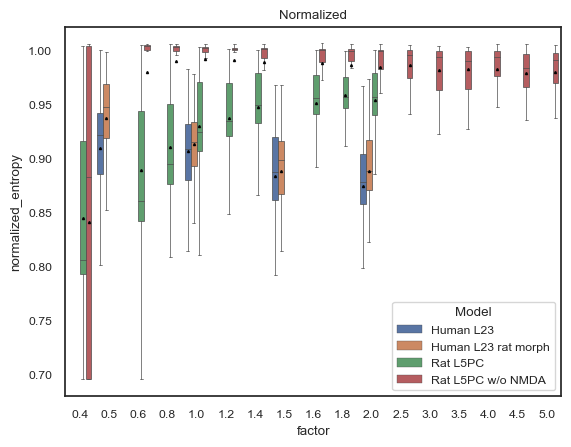

[Text(0.5, 1.0, 'Original')]

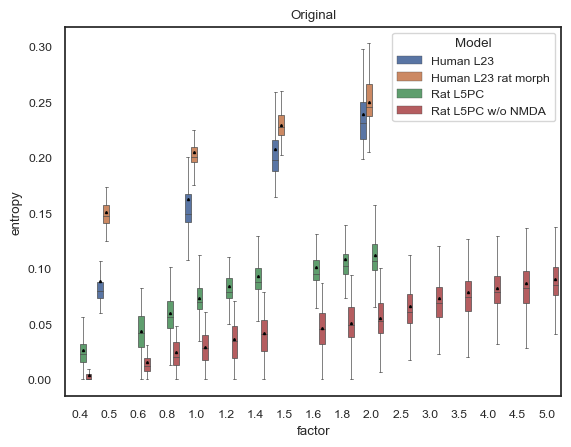

In [116]:


sns.boxplot(x="factor", y="normalized_entropy", data=factor_df, hue="Model", **box_plot_style).set(
    title='Normalized')  #, showmeans=True, meanprops={"marker": "o","markerfacecolor": "white","markeredgecolor": "black","markersize": "10"})

plt.show()

sns.boxplot(x="factor", y="entropy", data=factor_df, hue="Model", **box_plot_style).set(
    title='Original')


TypeError: Invalid object type at position 0

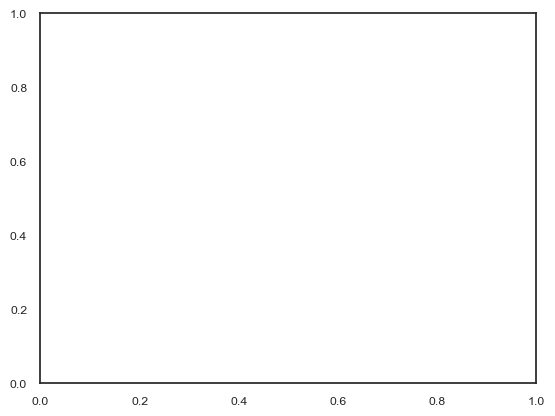

In [117]:
sns.lineplot(x='Average Rate Per Parameters', y="normalized_entropy", data=factor_df, hue="Model").set(
    title='Normalized')  #, showmeans=True, meanprops={"marker": "o","markerfacecolor": "white","markeredgecolor": "black","markersize": "10"})
# sns.lineplot(x='Average Rate Per Parameters', y="normalized_entropy", data=factor_df, hue="Model", **box_plot_style).set(
#     title='Normalized'
plt.show()

sns.lineplot(x='Average Rate Per Parameters', y="entropy", data=factor_df, hue="Model").set(
    title='Original')

<h3> Box plot by avarage rate<h3/>

TypeError: Invalid object type at position 0

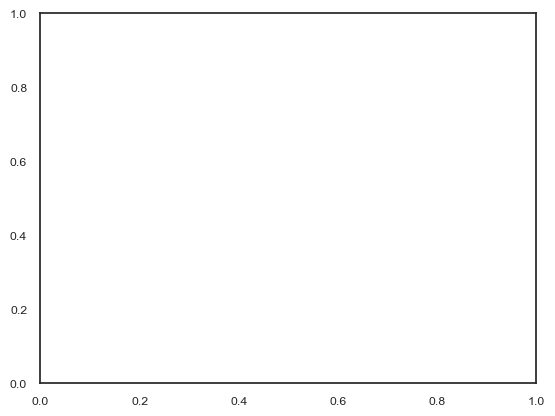

In [118]:
# line_plot_smooth_df=factor_df.copy()[["Model",'rate',"normalized_entropy",'entropy']]
# for g in pd.unique(line_plot_smooth_df["Model"]):
#     rate_data = line_plot_smooth_df[line_plot_smooth_df["Model"]==g]

sns.lineplot(x='Average Rate Per Parameters', y="normalized_entropy",
             data=factor_df[factor_df['Average Rate Per Parameters'] > 1], hue="Model").set(
    title='Normalized')
plt.grid(False)

plt.show()

fig, ax = plt.subplots()
# sns.boxplot(x="average_rate", y="entropy", data=factor_df[factor_df['Average Rate Per Parameters''>1, hue="Model",**box_plot_style,ax=ax).set(title='Original')
sns.lineplot(factor_df[factor_df['Average Rate Per Parameters'] > 1], x='Average Rate Per Parameters', y='entropy',
             hue="Model", ax=ax).set(
    title='Original')
x = np.linspace(df['Average Rate Per Parameters'].min() + 1e-11, factor_df['Average Rate Per Parameters'].max(), 100)
l = df['l_segemnt'].mean()
# ax.plot(x, [binary_ent(i * l / 1000., l) for i in x], '--', color='black', zorder=2)
ax.plot(x, [max_ent(i * l / 1000., l) for i in x], '--', color='black', zorder=2)
plt.grid(False)

plt.show()

# del line_plot_smooth_df
# line_plot_smooth_df

In [ ]:
sns.lineplot(x='factor', y="normalized_entropy",
             data=factor_df[factor_df['Average Rate Per Parameters'] > 1], hue="Model").set(
    title='Normalized')
plt.grid(False)

plt.show()

<h1> DC shift <h1/>

In [119]:
# dc_df = df[df["Model"] == 'NMDA']
dc_df = df[df['DC_test'] == True].copy()
dc_df[['full_tag', 'factor']]

,full_tag,factor
3188,Rat_L5b_PC_2_Hay_factor_0-2_DC_-10_CTW,0.2
3189,Rat_L5b_PC_2_Hay_factor_0-2_DC_-10_CTW,0.2
3190,Rat_L5b_PC_2_Hay_factor_0-2_DC_-10_CTW,0.2
3191,Rat_L5b_PC_2_Hay_factor_0-2_DC_-10_CTW,0.2
3192,Rat_L5b_PC_2_Hay_factor_0-2_DC_-10_CTW,0.2
...,...,...
5249,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,1.0
5250,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,1.0
5251,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,1.0
5252,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW,1.0


In [129]:
# sns.lineplot(dc_df,x='DC_factor',y='rate',hue="Model").set(title='Rate as function of DC factor')
dc_df[dc_df['normalized_entropy']>1.]

,full_tag,file,entropy,rate,n_spikes,Model,l_segemnt,index,Average Rate Per Parameters,factor,DC_factor,DC_test,normalizing_factor,normalized_entropy,Maximal Conductance
3323,Rat_L5b_PC_2_Hay_factor_0-2_DC_-110_CTW,ID_8_208316,0.006245,0.483333,29.0,Rat L5PC DC,60000,32,6.37402,0.2,-110.0,True,372.367608408083168725256812942882746630808183...,1.006331,0.00014
3557,Rat_L5b_PC_2_Hay_factor_0-2_DC_-50_CTW,ID_21_668206,0.063775,7.483333,449.0,Rat L5PC DC,60000,79,13.75081,0.2,-50.0,True,3825.36057714216757880323117874990017294121735...,1.000300,0.00014
3591,Rat_L5b_PC_2_Hay_factor_0-2_DC_-50_CTW,ID_59_81639,0.067378,8.000000,480.0,Rat L5PC DC,60000,35,13.75081,0.2,-50.0,True,4042.38012254499074426738431096078362860944116...,1.000073,0.00014
3614,Rat_L5b_PC_2_Hay_factor_0-2_DC_-50_CTW,ID_81_150946,0.057727,6.633333,398.0,Rat L5PC DC,60000,60,13.75081,0.2,-50.0,True,3461.45551076823474864540709748800085303179333...,1.000631,0.00014
3651,Rat_L5b_PC_2_Hay_factor_0-2_DC_-60_CTW,ID_38_584780,0.050775,5.683333,341.0,Rat L5PC DC,60000,67,12.26056,0.2,-60.0,True,3043.42902876964626883768623878755171341581065...,1.001004,0.00014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_-90_CTW,ID_98_997266,0.017866,1.650000,99.0,Rat L5PC w/o NMDA DC,60000,67,2.79789,1.0,-90.0,True,1068.02726273839091868560524545167617065658083...,1.003662,0.00070
4957,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_-90_CTW,ID_99_660806,0.017866,1.650000,99.0,Rat L5PC w/o NMDA DC,60000,13,2.79789,1.0,-90.0,True,1068.02726273839091868560524545167617065658083...,1.003662,0.00070
5088,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_10_CTW,ID_74_556493,0.061422,7.150000,429.0,Rat L5PC w/o NMDA DC,60000,70,15.41096,1.0,10.0,True,3683.71111569282221099827058585665747484533780...,1.000430,0.00070
5101,Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_10_CTW,ID_89_460905,0.060948,7.083333,425.0,Rat L5PC w/o NMDA DC,60000,71,15.41096,1.0,10.0,True,3655.22078286331217355240410355708486577245789...,1.000458,0.00070


                                         full_tag          file   entropy  \
3323      Rat_L5b_PC_2_Hay_factor_0-2_DC_-110_CTW   ID_8_208316  0.006245   
3557       Rat_L5b_PC_2_Hay_factor_0-2_DC_-50_CTW  ID_21_668206  0.063775   
3591       Rat_L5b_PC_2_Hay_factor_0-2_DC_-50_CTW   ID_59_81639  0.067378   
3614       Rat_L5b_PC_2_Hay_factor_0-2_DC_-50_CTW  ID_81_150946  0.057727   
3651       Rat_L5b_PC_2_Hay_factor_0-2_DC_-60_CTW  ID_38_584780  0.050775   
...                                           ...           ...       ...   
4956  Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_-90_CTW  ID_98_997266  0.017866   
4957  Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_-90_CTW  ID_99_660806  0.017866   
5088   Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_10_CTW  ID_74_556493  0.061422   
5101   Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_10_CTW  ID_89_460905  0.060948   
5244   Rat_L5b_PC_2_Hay_noNMDA_factor_1_DC_30_CTW  ID_89_460905  0.062954   

          rate  n_spikes                 Model  l_segemnt  index  \
3323  0

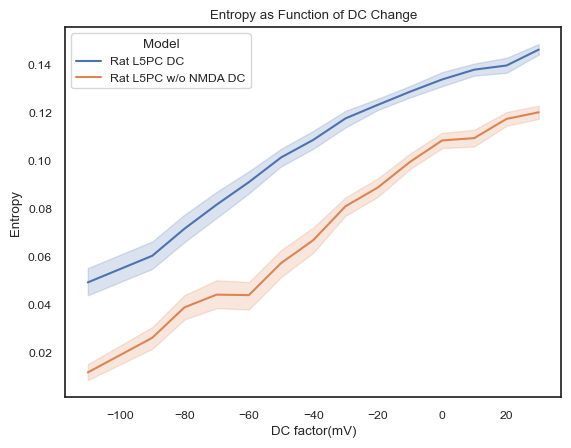

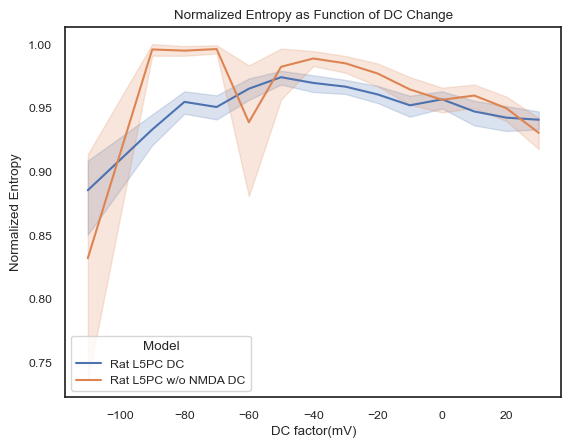

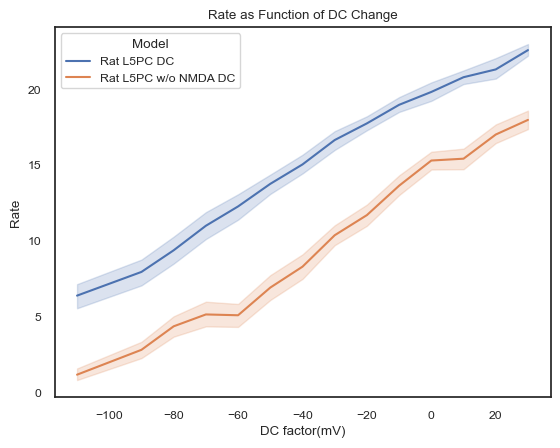

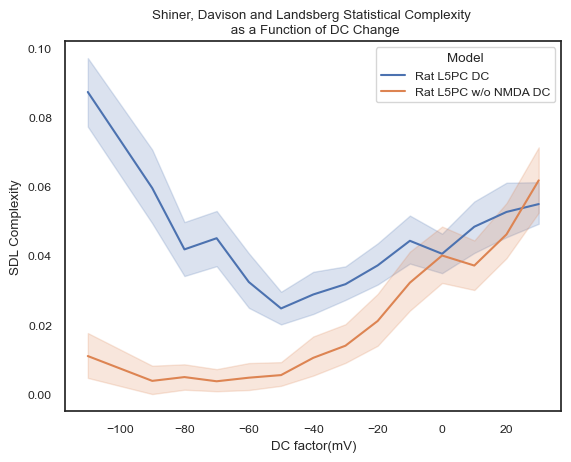

In [131]:
print((dc_df[dc_df['normalized_entropy']>1.]))
plt.grid(False)
# fig,ax=plt.subplots()
dc_df['entropy']=dc_df['entropy'].apply(lambda x:np.float64(x))
dc_df['normalized_entropy']=dc_df['normalized_entropy'].apply(lambda x:np.float64(x))
# sns.boxplot(data=dc_df, x='DC_factor', y='entropy',hue="Model",**box_plot_style)
ax = sns.lineplot(data=dc_df, x='DC_factor', y='entropy', hue="Model")
ax.set_xlabel("DC factor(mV)")
plt.title("Entropy as Function of DC Change")
ax.set_ylabel('Entropy')
savefig("ent_DC")

plt.show()
plt.grid(False)
# sns.boxplot(data=dc_df, x='DC_factor', y='normalized_entropy',hue="Model",**box_plot_style)
ax = sns.lineplot(data=dc_df, x='DC_factor', y='normalized_entropy', hue="Model")
ax.set_xlabel("DC factor(mV)")
ax.set_ylabel("Normalized Entropy")
plt.title("Normalized Entropy as Function of DC Change")
savefig("nent_DC")

plt.show()
plt.grid(False)
# sns.boxplot(data=dc_df, x='DC_factor', y='rate',hue="Model",**box_plot_style)
ax = sns.lineplot(data=dc_df, x='DC_factor', y='rate', hue="Model")
ax.set_xlabel("DC factor(mV)")
ax.set_ylabel("Rate")
plt.title("Rate as Function of DC Change")

# sns.lineplot(data=dc_df[dc_df["Model"]=='AMPA DC'], x='DC_factor', y='rate', hue='file')
# plt.legend('off')
savefig("rate_DC")

plt.show()
plt.grid(False)
dc_df['complexity'] = dc_df['normalized_entropy'].apply(lambda x: x * (1 - x))
dc_df['complexity'] = dc_df['complexity'].apply(lambda x: np.float64(x))
ax = sns.lineplot(data=dc_df, x='DC_factor', y='complexity', hue="Model")
ax.set_xlabel("DC factor(mV)")
ax.set_ylabel("SDL Complexity")

plt.title("Shiner, Davison and Landsberg Statistical Complexity \n as a Function of DC Change")
savefig("sdl_DC")
# sns.lineplot(data=dc_df, x='DC_factor', y='avarage_rate')

In [ ]:

sns.lineplot(x="factor", y="rate", data=factor_df, hue="Model").set(title='Rate by factor')
plt.grid(False)


In [ ]:
#factor as function of rate
temp_df = factor_df.copy()
temp_df['normalized_entropy'] = temp_df['normalized_entropy'].apply(lambda x: float(x))
temp_df['entropy'] = temp_df['entropy'].apply(lambda x: float(x))

# temp_df['tag']=temp_df['tag'].apply(lambda x:float(x))

sns.scatterplot(data=temp_df, x="factor", y="rate", hue="Model", size='normalized_entropy', sizes=(20, 200),
                alpha=0.3).set(title='Normalized Entropy as function of factor and rate')
plt.show()
sns.scatterplot(data=temp_df, x="factor", y="rate", hue="Model", size='entropy', sizes=(5, 200), alpha=0.3).set(
    title='Entropy as function of factor and rate')

In [ ]:
ax = plt.subplot()

sns.histplot(
    temp_df[temp_df['normalized_entropy'] <= 1.01], x="rate", y="normalized_entropy",
    bins=30, alpha=0.8, discrete=(False, False), hue="Model", log_scale=(False, False), cbar=False,
    cbar_kws=dict(shrink=.75),
    pthresh=.05, pmax=.9, ax=ax)
# plt.show()

In [ ]:
from sklearn import linear_model
from sklearn.metrics import r2_score

fig, ax = plt.subplots(1)
x = temp_df.rate.values[:, np.newaxis]
y = temp_df.entropy.values[:, np.newaxis]

regr = linear_model.LinearRegression()
regr.fit(x, y)
#
y_pred = regr.predict(x)
r2 = r2_score(y, y_pred)
plt.plot(x, regr.predict(x), color='red', alpha=0.4)
sns.histplot(
    temp_df, x="rate", y="entropy",
    bins=50, discrete=(False, False), hue="Model", log_scale=(False, False), cbar=False, cbar_kws=dict(shrink=.75),
    pthresh=.05, pmax=.9, ax=ax).set(title='$R^2$ = ' + str(r2))
plt.tight_layout()
# max_val = max(temp_df['rate'].max()/1000,temp_df['entropy'].max())
# ax.plot([0,max_val*1000],[0,max_val])

# plt.xticks(())
# plt.yticks(())


In [ ]:
sns.kdeplot(data=temp_df, x="rate", y="normalized_entropy", hue="Model", fill=True, log_scale=(False, False))

<h1>looking at sims<h1/>


In [ ]:
#looking at the files themselves
def create_template_series_for_model(df, full_tag, file):
    current = df[df['full_tag'] == full_tag].iloc[0].copy()
    series = pd.Series(np.nan, index=df.columns)
    series['full_tag'] = current['full_tag']
    series['factor'] = current['factor']
    series["Model"] = current["Model"]
    series['tag'] = current['tag']
    series['Average Rate Per Parameters'] = current['Average Rate Per Parameters']
    series['file'] = file
    series.name = None

    return series


def fill_sims_between_all_models(df):
    models = pd.unique(df['full_tag'])
    files = pd.unique(df['file'])
    cur_df = df.copy()
    for f in files:
        for i in models:
            series = df[df['file'] == f]['full_tag'] == i
            if series.any():
                continue
            template_series = create_template_series_for_model(df, i, f)
            cur_df = cur_df.append(template_series, ignore_index=True)
    return cur_df


sorting_dict = {'Current Synapse': 0, 'AMPA': 1, 'NMDA': 2}


def sort_by_tag(x):
    # print(x)
    data = x.apply(lambda y: sorting_dict[y])
    # print(type(data))
    return data


per_sim_df = temp_df.copy()
# per_sim_df.sort_values('factor',inplace=True)
# per_sim_df.sort_values(['file','group_order','factor'],inplace=True)
# per_sim_df.sort_values(by=['file'],inplace=True)
# per_sim_df['model_id']=per_sim_df["Model"].apply(lambda x:x[0])+per_sim_df['factor'].astype(str)
# g = sns.lineplot(data=per_sim_df, x='model_id', y="normalized_entropy", hue="file",legend=False)
# g._legend.remove()
# fill_sims_between_all_models(per_sim_df[per_sim_df["Model"] != 'Current Synapse']).sort_values(['file', "Model", 'factor'])
per_sim_df = fill_sims_between_all_models(per_sim_df)
per_sim_df['group_order'] = per_sim_df["Model"].apply(lambda x: sorting_dict[x])
per_sim_df.sort_values(['file', 'group_order', 'factor'], inplace=True)
per_sim_df.isnull().any(axis=1).sum()
#
# per_sim_df

In [ ]:
per_sim_df

In [ ]:
# per_sim_df.loc[per_sim_df['full_tag']=='Rat_L5b_PC_2_Hay_2_noNMDA_CTW','normalized_entropy']=np.nan
# per_sim_df.loc[per_sim_df['full_tag']=='Rat_L5b_PC_2_Hay_2_noNMDA_CTW',:].loc[:,'normalized_entropy']

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

x = pd.unique(per_sim_df['full_tag'])
x_model = [per_sim_df[per_sim_df['full_tag'] == i].iloc[0]["Model"] for i in x]
x_factor = [per_sim_df[per_sim_df['full_tag'] == i].iloc[0]['factor'] for i in x]
middle_points = []
cur_point = None
ax2_ticks_labels = []
fig, ax = plt.subplots(1)
for i in range(len(x_model)):
    if cur_point is None:
        cur_point = x_model[i]
        ax2_ticks_labels.append(cur_point)
    elif cur_point != x_model[i]:
        middle_points.append(i - 0.5)
        cur_point = x_model[i]
        ax2_ticks_labels.append(cur_point)
min_val = per_sim_df['normalized_entropy'].min()
max_val = per_sim_df['normalized_entropy'].max()
diff = max_val - min_val

# a = sns.lineplot(data=per_sim_df, x="full_tag", y="normalized_entropy", hue="file",legend=False,alpha=0.4,ax=ax,zorder=1)
# a.set(xticklabels=[])
# a.set_xlabel('')
for i in pd.unique(per_sim_df['file']):
    ax.plot(per_sim_df[per_sim_df['file'] == i]["full_tag"], per_sim_df[per_sim_df['file'] == i]["normalized_entropy"],
            alpha=0.4, zorder=1)
ax.set_xticklabels([])
# a.set_xlabel('')
boxes = []
for i in middle_points:
    boxes.append(Rectangle((i - 0.5, min_val), 1., max_val - min_val))
pc = PatchCollection(boxes, facecolor='white', edgecolor='white', zorder=2, alpha=0.75)
ax.add_collection(pc)
ax2_ticks = []
for i, mid in enumerate(middle_points):
    if i == 0:
        ax2_ticks.append((mid - 0.5) / 2.)
    else:
        ax2_ticks.append((mid - middle_points[i - 1]) / 2. + (middle_points[i - 1]))
    ax.vlines(mid, min_val, max_val, color='black', linewidth=2, alpha=0.8, zorder=3)
    ax.text(mid, min_val - 0.1 * diff, '|', horizontalalignment='center')
ax2_ticks.append(len(x) - (len(x) - middle_points[-1] - 0.5) / 2)
for i in range(len(ax2_ticks_labels)):
    ax.text(ax2_ticks[i], min_val - 0.2 * diff, ax2_ticks_labels[i], horizontalalignment='center')
for i in range(len(x_factor)):
    plt.text(i, min_val - 0.1 * diff, x_factor[i], horizontalalignment='center')
# ax2.set_xticks(ax2_ticks)
# ax2.set_xticklabels(ax2_ticks_labels)
plt.show()

In [ ]:
ax2_ticks, middle_points

In [ ]:
corr = temp_df[temp_df["Model"] == 'NMDA'].corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:

corr = temp_df[temp_df["Model"] == 'AMPA'].corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
sns.histplot(data=temp_df, x="factor", y="rate", hue="Model", alpha=0.7).set(
    title='Normalized Entropy as function of factor and rate')

In [ ]:
sns.scatterplot(data=temp_df, x="entropy", y="normalized_entropy", hue="Model", size='rate', sizes=(5, 200), alpha=0.4)

In [ ]:
#print avarage diffs
def get_entropies_by_group(group: str):
    data_dict = dict()
    # order={k:v for v,k in enumerate(df['tag'].unique().tolist())}
    order = sorted(df['tag'].unique().tolist(), key=lambda x: float(x.replace('-', '.')))

    # temp_df = df.sort_values(by=['file'])
    for index, row in df.iterrows():
        if group != row.group:
            continue
        if row.file not in data_dict:
            data_dict[row.file] = dict()
        if row.tag not in data_dict[row.file]:
            data_dict[row.file][row.tag] = dict()

        data_dict[row.file][row.tag]['normalized'] = row.normalized_entropy
        data_dict[row.file][row.tag]['original'] = row.entropy

    normalize_arr = np.zeros((len(data_dict), len(order)))
    original_arr = np.zeros((len(data_dict), len(order)))
    x = []
    x_flag = True
    for j, d_t in enumerate(data_dict.values()):
        for i, t in enumerate(order):
            if x_flag:
                x.append(i)
            if not t in d_t:
                normalize_arr[j, i] = (np.NAN)
                original_arr[j, i] = (np.NAN)
            else:
                normalize_arr[j, i] = (d_t[t]['normalized'])
                original_arr[j, i] = (d_t[t]['original'])
        x_flag = False
    return normalize_arr, original_arr, x, order


def z_score_f(mat, ax=1):
    min_value = np.nanmin(mat, axis=ax)
    max_value = np.nanmax(mat, axis=ax)
    if ax == 1:
        min_value = min_value[:, np.newaxis]
        max_value = max_value[:, np.newaxis]
    return (mat - min_value) / (max_value - min_value)


def plot_by_group(group):
    normalize_color = np.array([0., 0., 1.])
    original_color = np.array([1., 0., 0.])

    normalize_arr, original_arr, x, order = get_entropies_by_group(group)
    fig, ax = plt.subplots(4, gridspec_kw={'height_ratios': [15, 15, 15, 1]})
    fig.suptitle(group)
    ax[0].plot(x, normalize_arr.T, c=normalize_color, alpha=0.1)
    ax[0].plot(x, original_arr.T, c=original_color, alpha=0.1)
    ax[0].set_title('entropy as function of factor')
    ax[0].set_xticks(np.arange(len(order)), order)

    ax[1].set_title('Z Score Entropy')
    ax[1].plot(x, z_score_f(normalize_arr.T, 0), c=normalize_color, alpha=0.1)
    ax[1].plot(x, z_score_f(original_arr.T, 0), c=original_color, alpha=0.1)
    ax[1].plot([], [], c=normalize_color, label='Normalized Entropy')
    ax[1].plot([], [], c=original_color, label='Entropy')
    ax[1].plot([], [], c=normalize_color / 2, label='Normalized Entropy mean')
    ax[1].plot([], [], c=original_color / 2, label='Entropy mean')
    ax[1].set_xlabel('factor')
    ax[1].set_xticks(np.arange(len(order)), order)
    ax[1].plot(x, np.nanmean(z_score_f(normalize_arr.T, ax=0), axis=1), c=normalize_color / 2,
               label='Normalized Entropy')
    ax[1].plot(x, np.nanmean(z_score_f(original_arr.T, ax=0), axis=1), c=original_color / 2, label='Entropy')

    normalize_mean = np.nanmean((normalize_arr.T), axis=1)
    original_mean = np.nanmean((original_arr.T), axis=1)
    ax[2].set_title('Derivative')
    ax[2].plot(normalize_mean[1:] - normalize_mean[:-1], c=normalize_color, label='Normalized Entropy')
    ax[2].plot(original_mean[1:] - original_mean[:-1], c=original_color, label='Entropy')
    ax[2].set_xticks([], [])
    plt.tight_layout()

    ax[3].plot([], [], c=normalize_color, label='Normalized Entropy')
    ax[3].plot([], [], c=original_color, label='Entropy')
    ax[3].legend()
    ax[3].set_xticks([], [])
    ax[3].set_yticks([], [])
    # return ax

In [ ]:
plot_by_group('NMDA')

In [ ]:
plot_by_group('AMPA')

<h1> DC shift <h1/>

In [ ]:
dc_df = df[df["Model"] == 'NMDA']
dc_df = dc_df[dc_df['factor'] == 1.]
dc_df


In [ ]:
# sns.lineplot(dc_df,y='n',x='DC_factor')
sns.boxplot(data=dc_df, x='DC_factor', y='entropy')
plt.show()
sns.boxplot(data=dc_df, x='DC_factor', y='normalized_entropy')
plt.show()
sns.boxplot(data=dc_df, x='DC_factor', y='rate')
plt.show()
sns.lineplot(data=dc_df, x='DC_factor', y='rate')
sns.lineplot(data=dc_df, x='DC_factor', y='avarage_rate')